In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

2025-08-24 09:50:51.467546: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-24 09:50:51.884767: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-24 09:50:51.885003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-24 09:50:51.937121: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-24 09:50:52.060812: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-24 09:50:52.062465: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Load cleaned data

In [3]:
# Load data
data = pd.read_csv('../data/financial_data_clean.csv', index_col=0, parse_dates=True)
tsla_adj_close = data['TSLA_Adj Close'].asfreq('B').fillna(method='ffill')


# Split data

In [5]:
train_end = '2023-12-31'
test_start = '2024-01-01'
train_data = tsla_adj_close[:train_end]
test_data = tsla_adj_close[test_start:]

In [6]:
# Function to calculate evaluation metrics
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

In [7]:
# --- ARIMA Model ---
# Check stationarity
adf_result = adfuller(train_data)
print("ADF Test for TSLA Adj Close - Statistic:", adf_result[0], "p-value:", adf_result[1])

# Fit ARIMA model
arima_model = auto_arima(train_data, seasonal=False, stepwise=True, trace=True,
                         max_p=5, max_d=2, max_q=5, suppress_warnings=True)
arima_forecast = arima_model.predict(n_periods=len(test_data))

# Evaluate ARIMA
arima_metrics = calculate_metrics(test_data, arima_forecast)
print("\nARIMA Metrics (MAE, RMSE, MAPE):", arima_metrics)


ADF Test for TSLA Adj Close - Statistic: -1.1950455208198145 p-value: 0.6757233641201588
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14043.830, Time=4.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14065.901, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14065.756, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14065.762, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14064.621, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14068.624, Time=2.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14069.755, Time=0.66 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=14049.189, Time=3.58 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=14049.229, Time=4.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14066.624, Time=1.50 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=14067.488, Time=2.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=14068.061, Time=2.39 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=14051.176, Time=4.70 s

In [9]:
# --- LSTM Model ---
# Prepare data for LSTM
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

In [10]:
# Build LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Forecast with LSTM
test_predictions = []
current_batch = train_scaled[-seq_length:].reshape(1, seq_length, 1)
for _ in range(len(test_data)):
    pred = lstm_model.predict(current_batch, verbose=0)
    test_predictions.append(pred[0, 0])
    current_batch = np.roll(current_batch, -1, axis=1)
    current_batch[0, -1, 0] = pred[0, 0]
test_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()

Epoch 1/20
68/68 [==============================] - 8s 60ms/step - loss: 0.0098
Epoch 2/20
68/68 [==============================] - 4s 60ms/step - loss: 0.0027
Epoch 3/20
68/68 [==============================] - 4s 60ms/step - loss: 0.0024
Epoch 4/20
68/68 [==============================] - 4s 60ms/step - loss: 0.0022
Epoch 5/20
68/68 [==============================] - 4s 60ms/step - loss: 0.0020
Epoch 6/20
68/68 [==============================] - 4s 60ms/step - loss: 0.0022
Epoch 7/20
68/68 [==============================] - 4s 60ms/step - loss: 0.0017
Epoch 8/20
68/68 [==============================] - 4s 60ms/step - loss: 0.0018
Epoch 9/20
68/68 [==============================] - 4s 60ms/step - loss: 0.0018
Epoch 10/20
68/68 [==============================] - 4s 60ms/step - loss: 0.0017
Epoch 11/20
68/68 [==============================] - 4s 64ms/step - loss: 0.0016
Epoch 12/20
68/68 [==============================] - 4s 60ms/step - loss: 0.0015
Epoch 13/20
68/68 [==================

In [11]:
# Align predictions with test data
test_predictions = test_predictions[:len(test_data) - seq_length]
test_data_lstm = test_data[seq_length:]

# Evaluate LSTM
lstm_metrics = calculate_metrics(test_data_lstm, test_predictions)
print("\nLSTM Metrics (MAE, RMSE, MAPE):", lstm_metrics)


LSTM Metrics (MAE, RMSE, MAPE): (67.87775162519034, 77.57640216376761, 28.665266424600826)


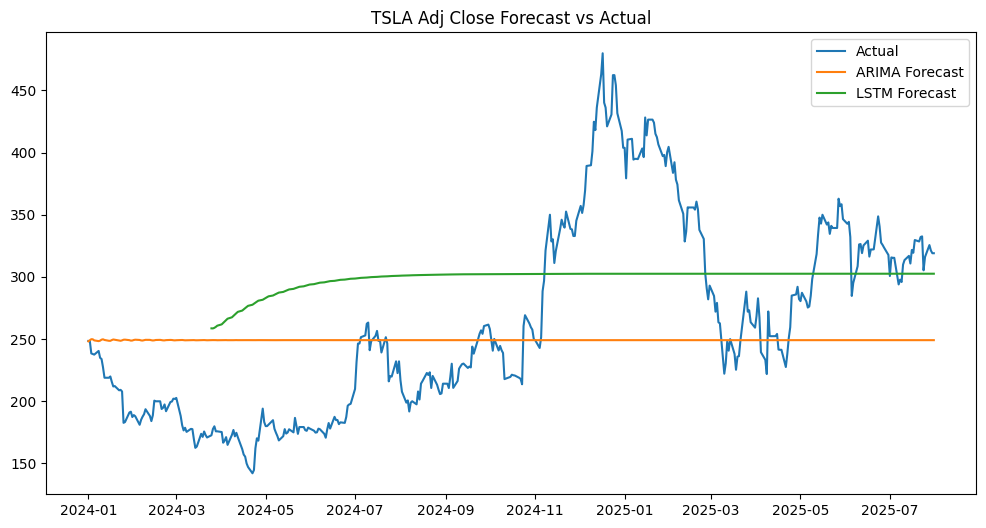

In [12]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual')
plt.plot(test_data.index, arima_forecast, label='ARIMA Forecast')
plt.plot(test_data_lstm.index, test_predictions, label='LSTM Forecast')
plt.title('TSLA Adj Close Forecast vs Actual')
plt.legend()
plt.savefig('../plots/forecast_comparison.png')
plt.show()
plt.close()


In [13]:

# Save results
results = pd.DataFrame({
    'Model': ['ARIMA', 'LSTM'],
    'MAE': [arima_metrics[0], lstm_metrics[0]],
    'RMSE': [arima_metrics[1], lstm_metrics[1]],
    'MAPE': [arima_metrics[2], lstm_metrics[2]]
})
results.to_csv('../data/forecast_metrics.csv', index=False)
print("\nModel Comparison Metrics:")
print(results)


Model Comparison Metrics:
   Model        MAE       RMSE       MAPE
0  ARIMA  63.760236  78.890603  24.224209
1   LSTM  67.877752  77.576402  28.665266
